# Figure 5
## Caution
- This problem uses parallel computations. If your computer cannot handle it due to core/memory limitations, reduce the number of jobs (<code>nj</code>)

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from time import ctime, time
from joblib import Parallel, delayed
from functions import *

np.set_printoptions(suppress=True)
#plt.style.use('classic')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'arial'

In [2]:
# Variable names for the parameters
omega_s, omega, n = r"$\omega_s$", r"$\omega$", '$n$'
nj = 5  # number of concurrent processes

In [3]:
print("code started", ctime())

code started Fri Mar 28 15:19:33 2025


There is excessive output so it is suppressed with <code>%%capture</code>. Feel free to look at output if you want.

In [4]:
%%capture
theta, fs, win, delay = 0.5, 150, [30, 40], 5 # fixed parameters for this experiment
n_repeats = 200
lengths = list(range(500, 5500, 500))
w_values = [fs//2, fs, fs*2]

def g(length, w, w_s, rho):
    y1, y2 = get_data(fs, win, length, delay, 0, None)
    n1 = get_noise(theta, length, fs, win)
    n2 = get_noise(theta, length, fs, win)
    x1 = normalize_signal(rho*y1 + (1-rho)*n1, fs, win)
    x2 = normalize_signal(rho*y2 + (1-rho)*n2, fs, win)
    score = css(x1, x2, w, w_s, 'closeness')[0]
    return score

data = []
for rho in [0, 0.8]:    
    for w in w_values:
        for l in lengths:
            w_s = w//2  # fixed
            res = Parallel(n_jobs=nj, verbose=1)(delayed(g)(l, w, w_s, rho) \
                                                for _ in range(n_repeats))
            for r in res:
                data.append([l, w, w_s, r, rho])
            
df1 = pd.DataFrame(data, columns=[n, omega, omega_s, "css", "rho"])

In [5]:
%%capture
l = 4000  # fixed
w_values = list(range(75, 325, 25))
w_s_values = [0, fs//4, fs//2]

data = []
for rho in [0, 0.8]:  
    for w in w_values:
        for w_s in w_s_values:
            if 2*w_s <= w:
                res = Parallel(n_jobs=nj, verbose=1)(delayed(g)(l, w, w_s, rho) \
                                                    for _ in range(n_repeats))
                for r in res:
                    data.append([l, w, w_s, r, rho])
            
df2 = pd.DataFrame(data, columns=[n, omega, omega_s, "css", "rho"])

In [6]:
%%capture
w = fs//2 # fixed
lengths = list(range(500, 5500, 500))
w_s_values = [0, w//4, w//2]

data = []
for rho in [0, 0.8]:    
    for w_s in w_s_values:
        for l in lengths:
            res = Parallel(n_jobs=nj, verbose=1)(delayed(g)(l, w, w_s, rho) \
                                                for _ in range(n_repeats))
            for r in res:
                data.append([l, w, w_s, r, rho])
            
df3 = pd.DataFrame(data, columns=[n, omega, omega_s, "css", "rho"])

In [7]:
print("done", ctime())

done Fri Mar 28 15:36:49 2025


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


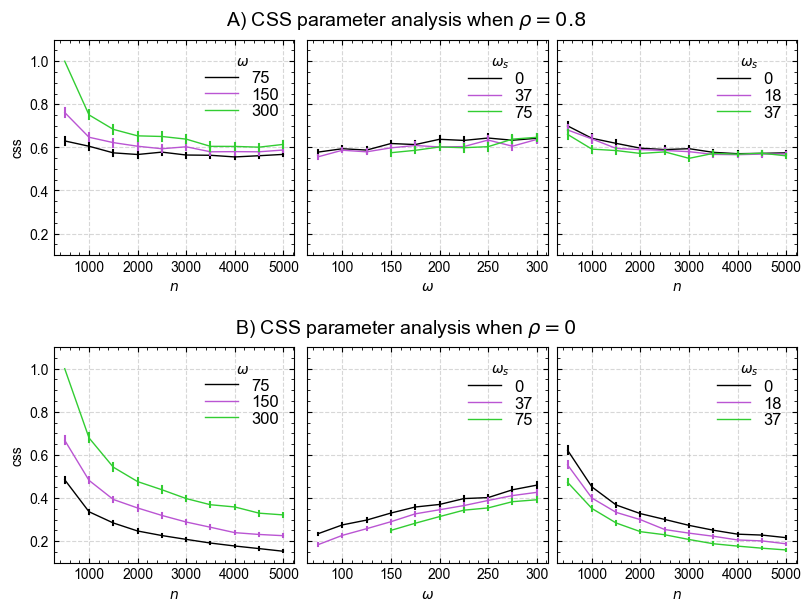

In [9]:
rho_vals, headers = [0.8, 0], ['A)', 'B)']
est, err, color = 'mean', 'bars', ['black','mediumorchid','limegreen']

fig = plt.figure(constrained_layout=True, figsize=(8,6))
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0.05)
i = 0
for row, subfig in enumerate(subfigs):
    rho, s = rho_vals[i], headers[i]
    subfig.suptitle(fr'{s} CSS parameter analysis when $\rho={rho_vals[i]}$', 
                    fontsize=14, weight='normal')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3, sharey=True)
    p1=sns.lineplot(df1.loc[df1['rho']==rho], ax=axs[0], x=n, y="css", lw=1,
                 hue=omega, estimator=est, err_style=err, palette=color)
    p2=sns.lineplot(df2.loc[df2['rho']==rho], ax=axs[1], x=omega, y="css", lw=1,
                 hue=omega_s, estimator=est, err_style=err, palette=color)
    p3=sns.lineplot(df3.loc[df3['rho']==rho], ax=axs[2], x=n, y="css", lw=1,
                 hue=omega_s, estimator=est, err_style=err, palette=color)

    for ax in axs:
        ax.minorticks_on()
        ax.tick_params(direction='in', which='both', right=True, top=True)
        ax.grid(alpha=0.5, ls='--')
        title = ax.get_legend().get_title().get_text()
        ax.legend(title=title, frameon=False, labelspacing=0.1, fontsize=12)
        ax.set_ylim(0.1, 1.1)
        
    i += 1

#plt.tight_layout()
make_directory('Figure5')
plt.savefig('Figure5/Figure5.eps', bbox_inches='tight')
plt.savefig('Figure5/Figure5.pdf', bbox_inches='tight')